# Geometric Brownian Motion model

### Maths

- the **Price** model is GBM:
\begin{align}
dS_t &= \mu S_t dt + \sigma S_t dB_t
\end{align}
with drift $\mu \in \mathbb{R}$ and volatility $\sigma > 0$ are constant.

- the **log Price** model is ABM (Arithmetic Brownian Motion)
\begin{align}
d \log{S_t} &= \left( \mu - \frac{1}{2}\sigma^{2} \right) dt + \sigma dB_t
\end{align}

Proof:
- use $S_t = \exp{X_t}$, ie $X_t = \log{S_t}$
- apply Itô's formula:
\begin{align}
\text{if} \,\, dX_t &= a_t dt + b_t dB_t \\
\text{then} \,\, df(X_t,t) &= \frac{\partial f}{\partial t}dt + \frac{\partial f}{\partial x}dX_t + \frac{1}{2}\frac{\partial^{2} f}{\partial x^{2}}b_{t}^{2} dt
\end{align}
with $f(x,t) = \exp{x}$
- by identification
\begin{align}
a_t &= \mu - \frac{1}{2}\sigma^{2} \\
b_t &= \sigma
\end{align}
and the result

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything()

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float32)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 3080 Ti
Total GPU Memory: 11.8 GB


# Create datasets

In [5]:
# Parameters for different timeframes
# - filename
# - input window size
# - output window size

params = {
    "1d" : ("/home/benjamin/Folders_Python/Portfolio/BTC/data/extract/outputBTCUSDT-2021-1-1-2025-11-24-1d.csv", 30, 7), # forecast next 7 days with past 30 days
    "1h" : ("/home/benjamin/Folders_Python/Portfolio/BTC/data/extract/outputBTCUSDT-2021-1-1-2025-11-24-1h.csv", 48, 6), # forecast next 6 hours with past 48 hours
    "5m" : ("/home/benjamin/Folders_Python/Portfolio/BTC/data/extract/outputBTCUSDT-2021-1-1-2025-11-24-5m.csv", 144, 48), # forecast next 48*5min with past 144*5min
}

In [6]:
# create dict for data storage
# data_logs is the dictionnary with log prices
data_logs = {}

# columns to process
cols = ['Open', 'High', 'Low', 'Close']

for timeframe, (filename, input_window, output_window) in params.items():
    # report out
    print(f"Timeframe: {timeframe}, Filename: {filename}, Input Window: {input_window}, Output Window: {output_window}")
    # load data
    df = pd.read_csv(filename, index_col='Open Time')
    n = len(df)
    # form log prices and their differences
    for c in cols:
        df['log_' + c] = np.log(df[c])
    df.dropna(inplace=True)
    # create datasets
    X = np.zeros((n - input_window - output_window + 1, input_window))
    Y = np.zeros((n - input_window - output_window + 1, output_window))
    for i in range(n-input_window-output_window):
        X[i, :] = df['log_Close'].values[i:i+input_window]
        Y[i, :] = df['log_Close'].values[i+input_window:i+input_window+output_window]
    # store in dict
    data_logs[timeframe] = (X, Y)

Timeframe: 1d, Filename: /home/benjamin/Folders_Python/Portfolio/BTC/data/extract/outputBTCUSDT-2021-1-1-2025-11-24-1d.csv, Input Window: 30, Output Window: 7
Timeframe: 1h, Filename: /home/benjamin/Folders_Python/Portfolio/BTC/data/extract/outputBTCUSDT-2021-1-1-2025-11-24-1h.csv, Input Window: 48, Output Window: 6
Timeframe: 5m, Filename: /home/benjamin/Folders_Python/Portfolio/BTC/data/extract/outputBTCUSDT-2021-1-1-2025-11-24-5m.csv, Input Window: 144, Output Window: 48


Draw some data

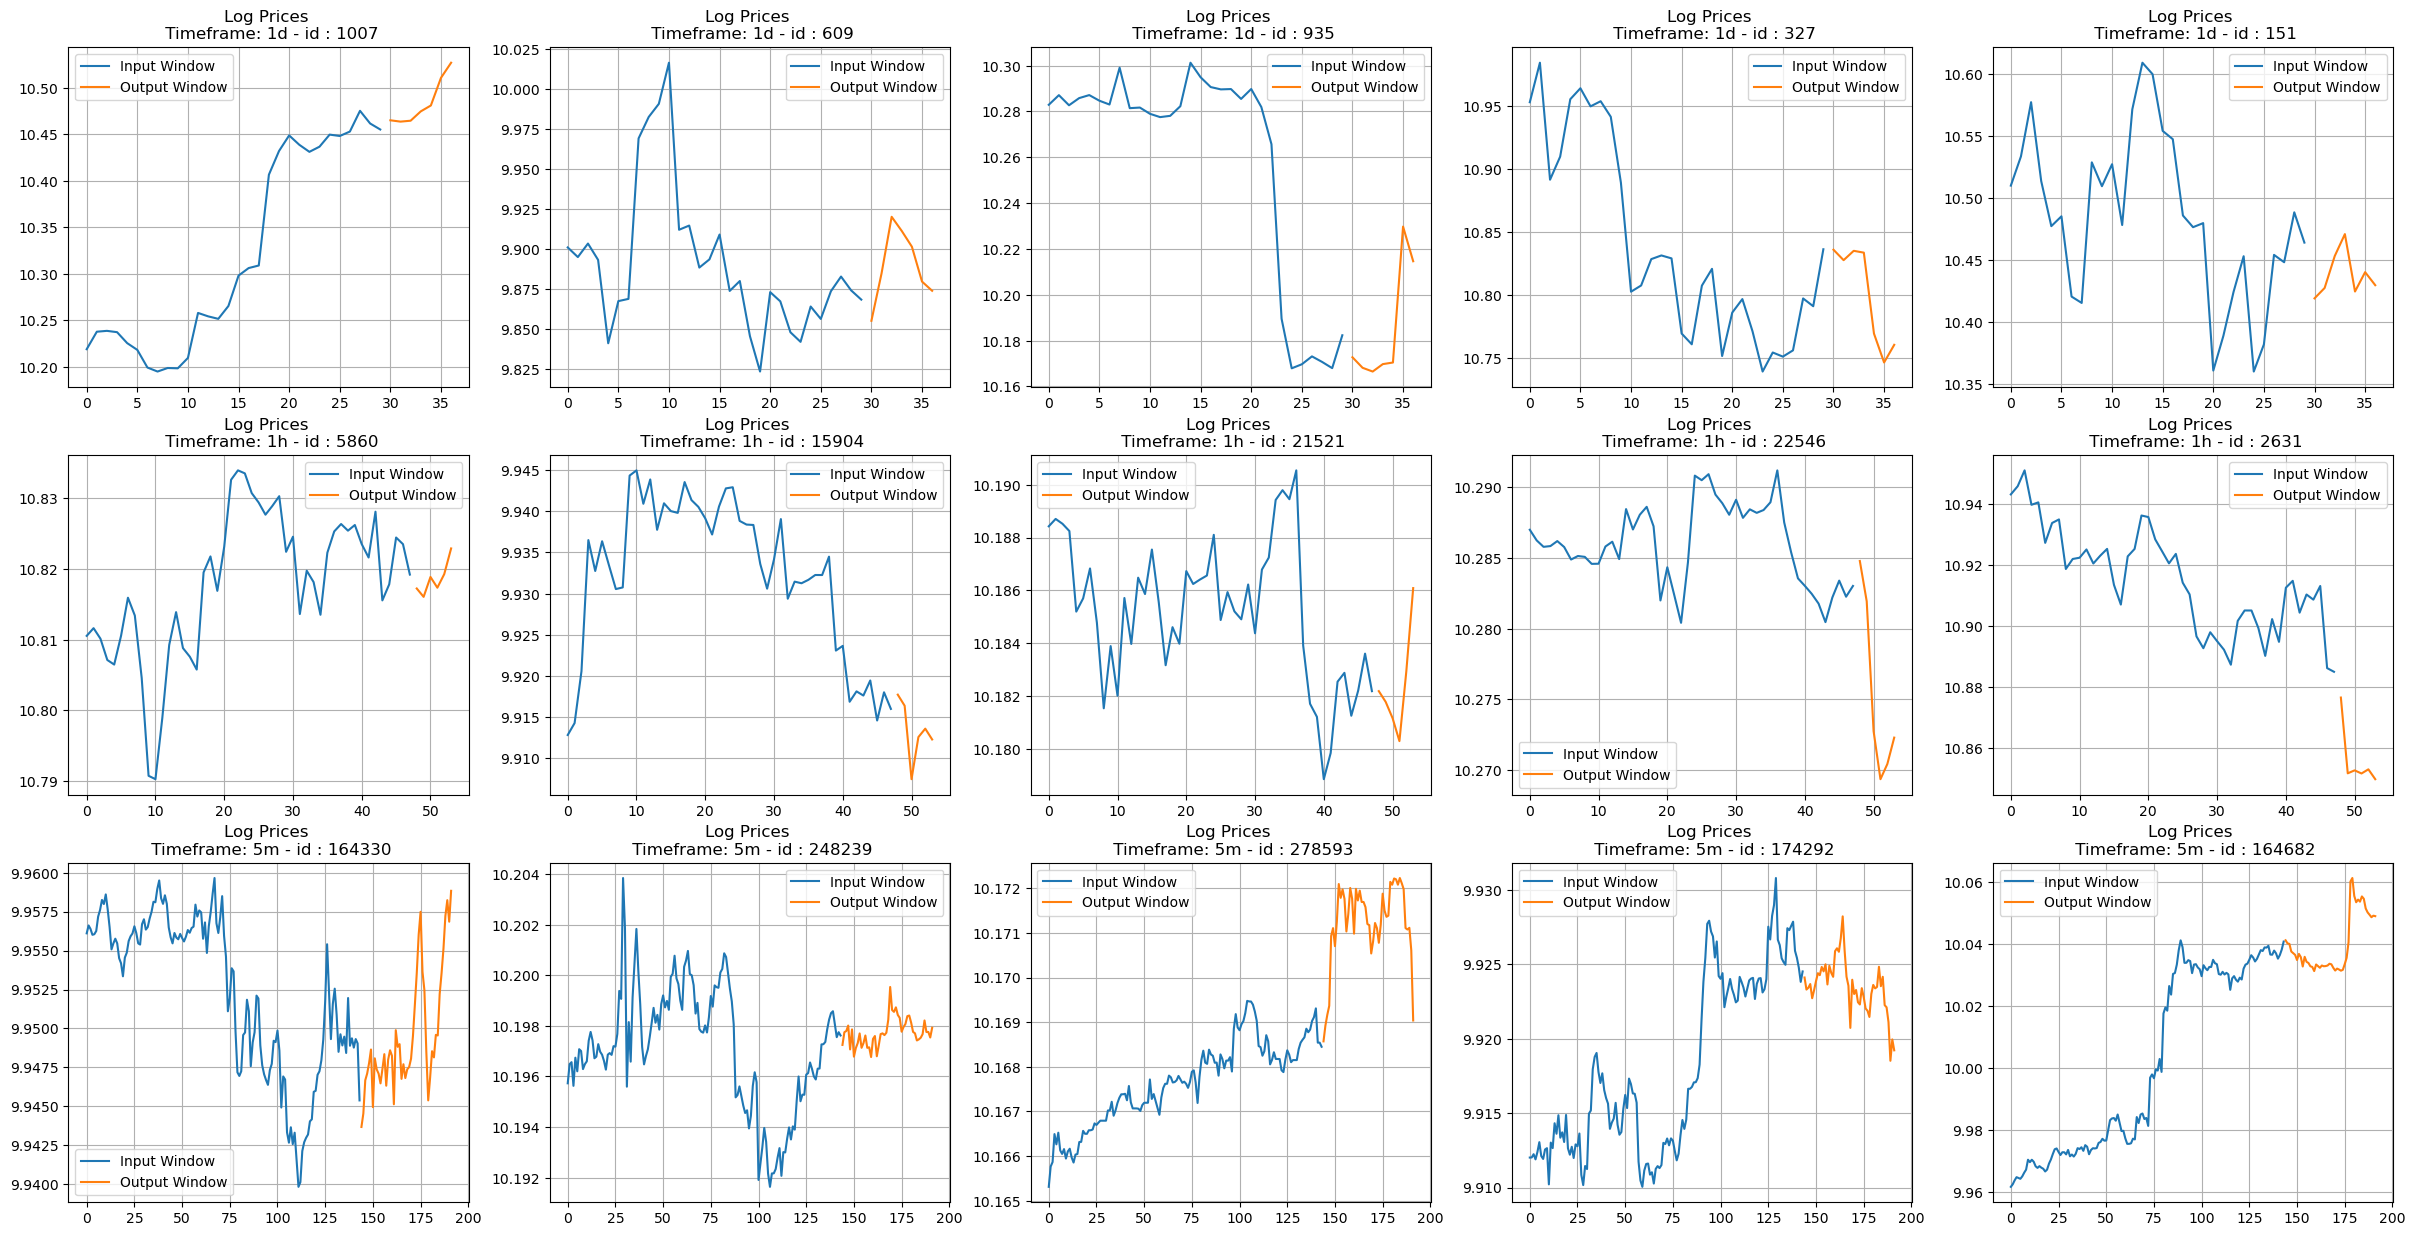

In [18]:
# for each timeframe, plot some examples of log prices
timeframes = ["1d", "1h", "5m"]
N = 5  # number of examples to plot

fig, ax = plt.subplots(nrows=len(timeframes), ncols=N, figsize=(N*6, len(timeframes)*5))

for i,timeframe in enumerate(timeframes):
    X, Y = data_logs[timeframe]
    idx = np.random.choice(len(X), size=N, replace=False)
    for j, id in enumerate(idx):
        # log prices
        ax[i,j].plot(X[id], label='Input Window')
        ax[i,j].plot(range(len(X[id]), len(X[id]) + len(Y[id])), Y[id], label='Output Window')
        ax[i,j].set_title(f'Log Prices \n Timeframe: {timeframe} - id : {id}')
        ax[i,j].grid()
        ax[i,j].legend()
        
plt.show()